#### code for dependency parsing to fetch verb-object pairs from raw and NERed sentences 

In [1]:
import json
import pprint
import re
import spacy

In [2]:
with open('data/utterances.json', 'r') as file:
    utter = json.load(file)

print(len(utter))

45797


In [1]:
# data cleaning
def data_clean():
    clean_text = []
    for id in utter:
        for req in utter[id]:
            if req != 'start' and 'feedback' not in req:
                req = re.sub(r'http://dbpedia.org/resource/', ' ', req)
                req = re.sub(r"-|_|'|/|!", ' ', req) 
                req = re.sub(r' +', ' ', req)
                req = re.sub(r'[t|T][e|E][l|L][l|L] [m|M][e|E] ', 'give ', req)
                if len(req.strip()) > 0:
                    clean_text.append(req)
    return clean_text

# preprocessed_text = data_clean()

In [35]:
# dependency parsing - input data for clustering (stanford)
import stanfordnlp
from spacy_stanfordnlp import StanfordNLPLanguage

def get_vo_dependency(all_text):
    vb_obj = [] 
    case_nmod =  []
    nsubj_nn =  []
    nmod_nn =  []
    cop_nn =  []
    nmod_prop =  []
    
    snlp = stanfordnlp.Pipeline(lang="en")
    nlp = StanfordNLPLanguage(snlp)

    for text in all_text:
#         print(text)
        if len(text) > 0:
            doc = nlp(text)
#             for token in doc:
#                 #if token.dep_ == 'nmod' and token.head.pos_ == 'PROPN':
#                 print(token.text, token.dep_, token.pos_, token.head.text, token.head.pos_,  [child for child in token.children])
#         break
            has_vo = False
            has_cop_nn = False
            has_nmod_nn = False
            has_nsubj_nn = False
            if any(token.dep_=='obj' and token.head.pos_ == 'VERB' for token in doc):
                for token in doc:
                    if token.dep_ == 'obj' and token.head.pos_ == 'VERB':
                        vb_obj.append((token.head.text, token.text))
                        has_vo = True
                        break
            elif not has_vo and any(token.dep_ == 'nmod' and token.head.pos_ == 'NOUN' for token in doc):
                for token in doc:
                    if token.dep_ == 'nmod' and token.head.pos_ == 'NOUN':
                        vb_obj.append((token.head.text, token.text))
                        has_nmod_nn = True
                        nmod_nn.append((text, token.head.text, token.text))
                        break
            elif not has_nmod_nn and any(token.dep_ == 'nsubj' and (token.head.pos_ == 'NOUN' or token.head.pos_ == 'PRON')
                                        for token in doc):
                for token in doc:
                    if token.dep_ == 'nsubj' and (token.head.pos_ == 'NOUN' or token.head.pos_ == 'PRON'):
                        vb_obj.append((token.head.text, token.text))
                        has_nsubj_nn = True
                        nsubj_nn.append((text, token.head.text, token.text))
                        break
            elif not has_nsubj_nn and any(token.dep_ == 'cop' and token.head.pos_ == 'NOUN' for token in doc):
                for token in doc:
                    if token.dep_ == 'cop' and token.head.pos_ == 'NOUN':
                        vb_obj.append((token.head.text, token.text))
                        has_cop_nn = True 
                        cop_nn.append((text, token.head.text, token.text))
                        break
#             elif not has_cop_nn and any(token.dep_ == 'nmod' and token.head.pos_ == 'NOUN' for token in doc):
#                 for token in doc:
#                     if token.dep_ == 'nmod' and token.head.pos_ == 'NOUN':
#                         vb_obj.append((token.head.text, token.text))
#                         has_nmod_nn = True
#                         nmod_nn.append((text, token.head.text, token.text))
#                         break
#             elif not has_nmod_nn and any(token.dep_ == 'nsubj' and (token.head.pos_ == 'NOUN' or token.head.pos_ == 'PRON')
#                                         for token in doc):
#                 for token in doc:
#                     if token.dep_ == 'nsubj' and (token.head.pos_ == 'NOUN' or token.head.pos_ == 'PRON'):
#                         vb_obj.append((token.head.text, token.text))
#                         has_nsubj_nn = True
#                         nsubj_nn.append((text, token.head.text, token.text))
#                         break
            elif not has_nsubj_nn and any(token.dep_ == 'nmod' and token.head.pos_ == 'PROPN' for token in doc):
                for token in doc:
                    if token.dep_ == 'nmod' and token.head.pos_ == 'PROPN':
                        vb_obj.append((token.head.text, token.text))
                        nmod_prop.append((text, token.head.text, token.text))
                        break
            else:
                for token in doc:
                    if token.dep_ == 'case' and token.head.dep_ == 'nmod':
                        vb_obj.append((token.text, token.head.text))
                        case_nmod.append((text, token.head.text, token.text))
                        break
    return vb_obj, case_nmod, nsubj_nn, nmod_nn, cop_nn, nmod_prop   
                
# get_vo_dependency(['who is Person'])
# vb_obj, case_nmod, nsubj_nn, nmod_nn, cop_nn, nmod_prop = get_vo_dependency()

In [107]:
# save vb-obj pairs for orginal text w/o recognised entities 
print(vb_obj)
# write to file 
with open('data/vb_obj_raw.txt', 'w') as f: 
    f.write(str(vb_obj))

[('Who', 'George'), ('Who', 'Macron'), ('Who', 'Emmanuel'), ('Who', 'Einstein'), ('WHER', 'PARIS'), ('WHO', 'GEORGE'), ('WHO', 'MACRON'), ('get', 'location'), ('dbpedia', 'about'), ('learn', 'Albert'), ('load', 'Albert'), ('get', 'location'), ('learn', 'Planet'), ('load', 'Planet'), ('dbpedia', 'about'), ('get', 'location'), ('learn', 'Albert'), ('get', 'location'), ('get', 'location'), ('directed', 'Edge'), ('plot', 'Titanic'), ('dbpedia', 'about'), ('who', 'sachin'), ('do', 'what'), ('anthem', 'india'), ('birthdate', 'Albert'), ('who', 'sachin'), ('learn', 'Albert'), ('load', 'Albert'), ('founder', 'car'), ('created', 'you'), ('what', 'life'), ('what', 'life'), ('what', 'drawbacks'), ('have', 'bones'), ('name', 'cat'), ('get', 'old'), ('Who', 'Lula'), ('care', 'newborn'), ('have', 'disease'), ('drugs', 'Fever'), ('dbpedia', 'about'), ('get', 'location'), ('who', 'Angela'), ('today', 'is'), ('who', 'you'), ('capital', 'china'), ('dbpedia', 'about'), ('about', 'Rachmaninov'), ('get', '

In [33]:
# vectorize vb-obj pair using spacy vectors for clustering

def prepare_input_rep(vb_obj):
    import spacy
    nlp = spacy.load("/tmp/la_vectors_wiki_lg") # fasttext subword vectors

    vo_rep = []
    lab_vec_map = {}

    for i, pair in enumerate(vb_obj):
        print(i)
        doc = nlp((' '.join(pair)).lower())
        print(doc.text)
        vo_rep.append(doc.vector) # add avg vector
        lab_vec_map[str(doc.vector)] = doc.text
        #print(lab_vec_map[str(doc.vector)])
        #break 
    return vo_rep, lab_vec_map

# vo_rep, lab_vec_map = prepare_input_rep()

In [37]:
# run the pipeline on ner-ed data
import ast, pickle, re

with open('ner_requests.txt', 'r') as f:
    lines = f.read()
    lines = [line for line in ast.literal_eval(lines) if len(line) > 0]
    print(len(lines))
    mlines = []
    for line in lines:
        line = re.sub(r'[t|T][e|E][l|L][l|L] [m|M][e|E] ', 'give ', line)
        mlines.append(line)
    
    print('after modification!!: ', len(mlines))
    gen_vo_pair, case_nmod, nsubj_nn, nmod_nn, cop_nn, nmod_prop = get_vo_dependency(mlines)
#    print(gen_vo_pair)
#     print('CASE_NMOD!!!: ',case_nmod)
#     print('NSUBJ_NN!!!: ',nsubj_nn)
#     print('NMOD_NN!!!: ',nmod_nn)
#     print('COP_NN!!!: ',cop_nn)
#     print('NMOD_PROP!!!: ',nmod_prop)
    vo_rep, lab_vec_map = prepare_input_rep(gen_vo_pair)
    
    print('vec len: ',len(vo_rep))
    
    with open('data/vb_obj_ftext_ner.pkl', 'wb') as fl:
        pickle.dump(vo_rep, fl)

    with open('data/vb_obj_ner_ftextLabels.pkl', 'wb') as fl:
        pickle.dump(lab_vec_map, fl)
    
    print('done pickling.!')

10909
after modification!!:  10909
Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/rrichajalota/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/rrichajalota/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/home/rrichajalota/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/rrichajalota/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/home/rrichajalota/stanfordnlp_resources/en_ewt_models/en_ewt_parser.pt', 'pret

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch

[('Who', 'Church'), ('Who', 'Person'), ('Who', 'Person'), ('Who', 'Person'), ('WHO', 'Person'), ('swife？', 'Who'), ('get', 'City'), ('learn', 'Person'), ('load', 'Person'), ('get', 'City'), ('get', 'City'), ('learn', 'Person'), ('Person', 'who'), ('get', 'City'), ('What', 'Organization'), ('What', 'Organization'), ('get', 'City'), ('directed', 'MusicGroup'), ('birthdate', 'Person'), ('load', 'Person'), ('name', 'cat'), ('get', 'City'), ('who', 'Person'), ('get', 'City'), ('get', 'City'), ('Person', 'who'), ('what', 'Organization'), ('learn', 'County'), ('mayor', 'Place'), ('Who', 'Person'), ('Who', 'Mountain'), ('What', 'Country'), ('City', 'Germany'), ('City', 'Country'), ('Place', 'Lithuania'), ('Place', 'Country'), ('Person', 'who'), ('who', 'Person'), ('What', 'Place'), ('capital', 'Country'), ('population', 'Country'), ('has', 'members'), ('members', 'MusicGroup'), ('members', 'MusicGroup'), ('learn', 'Person'), ('load', 'Person'), ('get', 'City'), ('learning', 'tower'), ('Tower',

/usr/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from en_model.vectors to en_model.vectors_999994, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


0
who church
1
who person
2
who person
3
who person
4
who person
5
swife？ who
6
get city
7
learn person
8
load person
9
get city
10
get city
11
learn person
12
person who
13
get city
14
what organization
15
what organization
16
get city
17
directed musicgroup
18
birthdate person
19
load person
20
name cat
21
get city
22
who person
23
get city
24
get city
25
person who
26
what organization
27
learn county
28
mayor place
29
who person
30
who mountain
31
what country
32
city germany
33
city country
34
place lithuania
35
place country
36
person who
37
who person
38
what place
39
capital country
40
population country
41
has members
42
members musicgroup
43
members musicgroup
44
learn person
45
load person
46
get city
47
learning tower
48
tower place
49
get city
50
learn more
51
load place
52
person who
53
person who
54
person who
55
person who
56
person who
57
person who
58
who person
59
give capital
60
learn person
61
load person
62
load person
63
load person
64
learn person
65
get city
66

593
president country
594
president country
595
published games
596
head organization
597
head organization
598
head organization
599
head organization
600
head windsor
601
head place
602
heads organization
603
heads organization
604
who person
605
profess religion
606
head organization
607
head organization
608
head organization
609
head organization
610
give website
611
who person
612
site landmarks
613
attractions administrativearea
614
attractions administrativearea
615
attractions place
616
attractions place
617
attractions administrativearea
618
head organization
619
head organization
620
head organization
621
head organization
622
head organization
623
head organization
624
head organization
625
head organization
626
attractions administrativearea
627
give creativework
628
give creativework
629
country america
630
country country
631
capital country
632
get city
633
capital country
634
city leipzig
635
city place
636
get city
637
person who
638
who person
639
who person
640
who 

1134
place person
1135
house frank
1136
house person
1137
marry who
1138
output city
1139
who person
1140
get city
1141
capital country
1142
get city
1143
president country
1144
who person
1145
person ist
1146
person ist
1147
who minister
1148
get city
1149
mayor place
1150
what event
1151
what event
1152
captial country
1153
height country
1154
person who
1155
who person
1156
insurance who
1157
who person
1158
get city
1159
who person
1160
who person
1161
get city
1162
who person
1163
what organization
1164
person who
1165
what organization
1166
what place
1167
what place
1168
learn person
1169
capital country
1170
capital country
1171
what place
1172
what place
1173
what place
1174
what place
1175
who person
1176
what place
1177
who person
1178
person who
1179
learn person
1180
load person
1181
person who
1182
get city
1183
what country
1184
learn person
1185
load person
1186
capital country
1187
what bodyofwater
1188
person who
1189
about team
1190
population country
1191
person who

1651
person who
1652
who person
1653
get city
1654
start year
1655
who maher
1656
who person
1657
what organization
1658
person who
1659
head country
1660
head country
1661
head country
1662
head country
1663
head country
1664
head country
1665
know what
1666
weather place
1667
who president
1668
who person
1669
who person
1670
give capital
1671
who person
1672
capital country
1673
know anything
1674
what city
1675
cities city
1676
who person
1677
who person
1678
who person
1679
what oruniversity
1680
learn university
1681
university university
1682
design buildings
1683
population place
1684
who person
1685
what name
1686
who person
1687
load administrative
1688
learn city
1689
learn organization
1690
give age
1691
person who
1692
capital country
1693
president country
1694
what creativework
1695
person who
1696
who person
1697
person who
1698
who person
1699
who person
1700
born person
1701
who person
1702
who country
1703
what person
1704
paris city
1705
speak language
1706
person w

2234
mountain country
2235
who person
2236
leader country
2237
what organization
2238
what place
2239
what place
2240
wrote creativework
2241
city mountain
2242
learn city
2243
load city
2244
capital country
2245
capital country
2246
person who
2247
population cities
2248
population cities
2249
population cities
2250
population cities
2251
city country
2252
population cities
2253
population country
2254
population country
2255
presedent country
2256
presedent country
2257
rule world
2258
rule world
2259
what organization
2260
what organization
2261
plays organization
2262
whats population
2263
wife person
2264
circumference place
2265
distance place
2266
has albums
2267
who person
2268
capital country
2269
who person
2270
capitol country
2271
city country
2272
manager season
2273
manager season
2274
what organization
2275
manager organization
2276
manager organization
2277
what product
2278
who person
2279
person who
2280
king country
2281
author book
2282
what place
2283
place who
228

2929
who person
2930
person who
2931
person who
2932
who person
2933
what place
2934
who person
2935
capital country
2936
won worldcup
2937
capital country
2938
capital place
2939
capital place
2940
country country
2941
who person
2942
get city
2943
who person
2944
answer questions
2945
get city
2946
who person
2947
give capital
2948
who person
2949
who person
2950
person who
2951
who person
2952
person who
2953
get city
2954
get city
2955
get city
2956
what place
2957
capital country
2958
capital country
2959
learn person
2960
load person
2961
give what
2962
season administrativearea
2963
season administrative
2964
had brothers
2965
place who
2966
get city
2967
learn country
2968
load country
2969
load country
2970
give bout
2971
what event
2972
learn person
2973
president country
2974
president person
2975
president country
2976
who person
2977
who johannes
2978
like person
2979
who un
2980
what research
2981
who hellmann
2982
person who
2983
person who
2984
who person
2985
capital a

3731
who person
3732
person who
3733
person who
3734
person who
3735
who person
3736
who person
3737
who person
3738
version language
3739
version language
3740
person who
3741
person who
3742
capital country
3743
population country
3744
who person
3745
president country
3746
get city
3747
governor place
3748
who person
3749
wife person
3750
population place
3751
coordinates place
3752
get city
3753
distance place
3754
distance place
3755
learn creative
3756
learn creative
3757
learn creative
3758
learn creative
3759
learn creative
3760
learn person
3761
load person
3762
have siblings
3763
have brothers
3764
who person
3765
who person
3766
get city
3767
what sicher
3768
get city
3769
person who
3770
like country
3771
people country
3772
place thorne
3773
win awards
3774
win awards
3775
who musicgroup
3776
who city
3777
what organization
3778
who person
3779
who person
3780
person me
3781
president country
3782
coach organization
3783
wife person
3784
what organization
3785
like that
37

load person
4325
get city
4326
who person
4327
who person
4328
who person
4329
director creativework
4330
movies creativework
4331
president country
4332
president who
4333
query dbpedia
4334
name person
4335
place temperature
4336
who person
4337
person who
4338
what place
4339
place earth
4340
who person
4341
distance place
4342
minister place
4343
person who
4344
person who
4345
what landmarksorhistoricalbuildings
4346
town administrativearea
4347
who person
4348
population place
4349
population place
4350
get city
4351
population place
4352
abitants place
4353
playes cricket
4354
who person
4355
get city
4356
capital country
4357
get city
4358
city minnesotta
4359
ticker organization
4360
symbol organization
4361
president country
4362
vicepresident country
4363
vicepresident country
4364
price dollar
4365
justicia country
4366
who person
4367
character person
4368
die age
4369
number people
4370
minister place
4371
load type
4372
what city
4373
what organization
4374
remind images

4797
place who
4798
person who
4799
what place
4800
who person
4801
who person
4802
speak language
4803
what organization
4804
give languages
4805
person who
4806
person who
4807
give capital
4808
who person
4809
who person
4810
what organization
4811
who person
4812
capital country
4813
who musicgroup
4814
who person
4815
who person
4816
who person
4817
have inhabitants
4818
give place
4819
artist 70s
4820
distance between
4821
distance city
4822
place hwo
4823
what place
4824
capital city
4825
capital country
4826
mayor city
4827
give coordinates
4828
give coordinates
4829
learn city
4830
entity creativework
4831
learn republic
4832
load republic
4833
republic place
4834
schwarzenneger language
4835
arnold language
4836
arnold dbpedia
4837
link person
4838
president country
4839
who person
4840
who person
4841
who person
4842
who person
4843
name actor
4844
president country
4845
president country
4846
minister country
4847
who person
4848
person who
4849
what organization
4850
what 

5328
have relations
5329
who person
5330
who person
5331
minister place
5332
get city
5333
learn country
5334
load country
5335
load country
5336
who person
5337
get city
5338
president country
5339
employee university
5340
has aktiengesellschaft
5341
organization who
5342
band from
5343
who musicgroup
5344
who person
5345
get city
5346
know person
5347
person who
5348
learn person
5349
show quaterbacks
5350
who person
5351
person who
5352
mountain country
5353
mountain place
5354
president country
5355
know organization
5356
give something
5357
compare policies
5358
compare policies
5359
president country
5360
wife president
5361
ministerof who
5362
who person
5363
who person
5364
who person
5365
get weather
5366
person who
5367
population city
5368
what sausage
5369
minister country
5370
planet place
5371
get city
5372
mountains creativework
5373
descobriu country
5374
person who
5375
who person
5376
use language
5377
give lake
5378
who person
5379
who person
5380
place hight
5381
wh

5892
city lebanon
5893
city country
5894
capital country
5895
get city
5896
minister who
5897
revenue organization
5898
person who
5899
learn creative
5900
who person
5901
preschool place
5902
who person
5903
show images
5904
person who
5905
who person
5906
sign ramps
5907
want voice
5908
father nation
5909
father nation
5910
who musicgroup
5911
person who
5912
person who
5913
won cup
5914
show images
5915
person who
5916
person who
5917
get city
5918
get city
5919
who person
5920
know language
5921
what country
5922
get city
5923
river country
5924
found restaurant
5925
found restaurant
5926
capital place
5927
capital city
5928
who person
5929
name mla
5930
get city
5931
minister italy
5932
minister country
5933
who person
5934
distance city
5935
distance city
5936
malaria country
5937
city place
5938
what place
5939
population place
5940
win times
5941
get city
5942
get city
5943
give year
5944
son who
5945
minister place
5946
city bangalore
5947
city city
5948
countries organization

done pickling.!


NameError: name 'StandardScaler' is not defined

In [1]:
#print(nmod_nn)


In [2]:
#print(nsubj_nn)


In [3]:
#print(case_nmod)

In [4]:
#print(nmod_prop)

/home/rrichajalota/work/DBpedia Chatlog Analysis/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/rrichajalota/work/DBpedia Chatlog Analysis/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65311 missing from current font.
  font.set_text(s, 0, flags=flags)


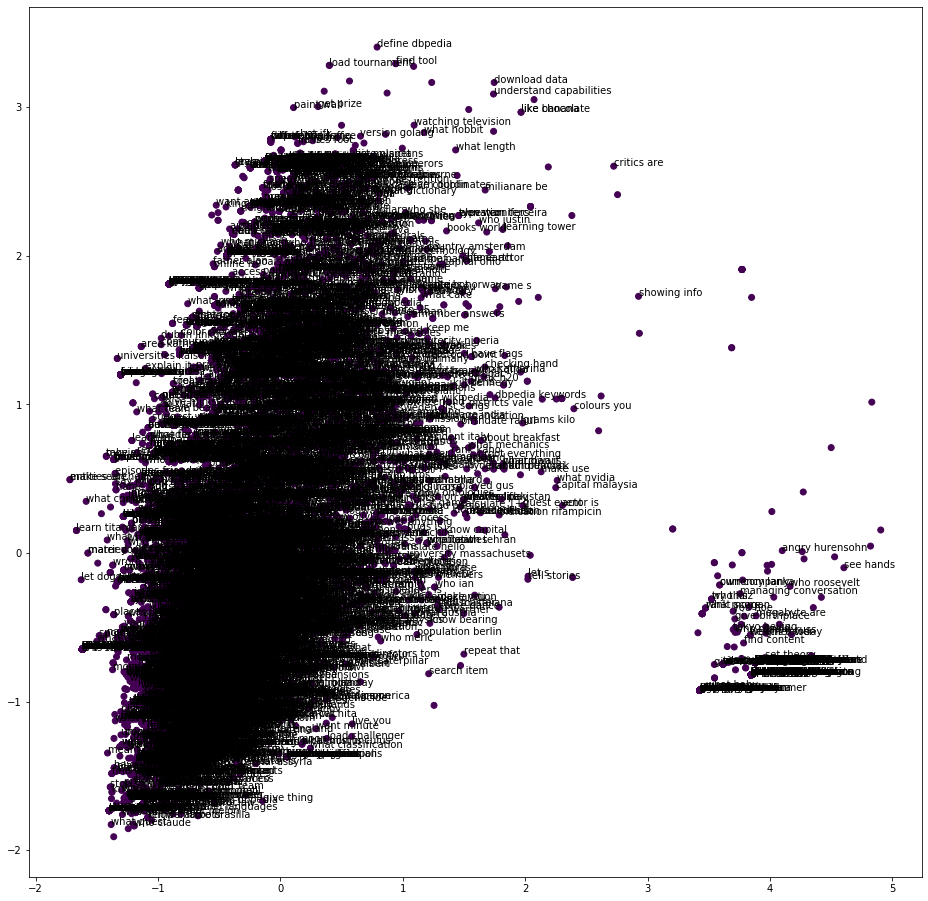

In [6]:

# print('COP_NN!!!: ',cop_nn)


In [7]:
# print('NMOD_PROP!!!: ',nmod_prop)

In [8]:
# print('CASE_NMOD!!!: ',case_nmod)


In [9]:
# print('NSUBJ_NN!!!: ',nsubj_nn)

In [10]:
# print('NMOD_NN!!!: ',nmod_nn)